In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import datetime as dt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import time 
%matplotlib inline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import unicodedata
import string
from sklearn.svm import SVR

# First explorations 

In [78]:
path = 'les-arbres.csv'
df = pd.read_csv(path, sep = ';')

In [3]:
print(df.shape)
df.head()

(222170, 20)


,IDBASE,TYPEEMPLACEMENT,DOMANIALITE,ARRONDISSEMENT,COMPLEMENTADRESSE,NUMERO,LIEU / ADRESSE,IDEMPLACEMENT,CIRCONFERENCEENCM,HAUTEUR (m),STADEDEVELOPPEMENT,PEPINIERE,ESPECE,VARIETEOUCULTIVAR,GENRE,DATEPLANTATION,REMARQUABLE,LIBELLEFRANCAIS,OBJECTID,geo_point_2d
0,296880.0,Arbre,Alignement,PARIS 8E ARRDT,face43,NaN,AVENUE FRANKLIN D ROOSEVELT,000404022,130.0,12.0,A,Inconnue,hippocastanum,NaN,Aesculus,1700-01-01T01:02:49+00:53,0.0,Marronnier,97992,"48.8680417817, 2.31038073393"
1,2000397.0,Arbre,Alignement,BOIS DE BOULOGNE,lampadaire,NaN,BOULEVARD DU COMMANDANT CHARCOT,000202038,185.0,16.0,A,NaN,hippocastanum,NaN,Aesculus,1700-01-01T01:02:49+00:53,0.0,Marronnier,98001,"48.8762405044, 2.25636279639"
2,2001631.0,Arbre,Alignement,PARIS 8E ARRDT,NaN,NaN,AVENUE DUTUIT,000406004,158.0,14.0,A,Inconnue,n. sp.,NaN,Aesculus,2000-01-01T02:00:00+01:00,0.0,Marronnier,98004,"48.8665918946, 2.31599668868"
3,2004952.0,Arbre,Alignement,BOIS DE VINCENNES,NaN,NaN,ROUTE DE LA FALUERE,000301048,0.0,0.0,NaN,Inconnue,platyphyllos,NaN,Tilia,1700-01-01T01:02:49+00:53,0.0,Tilleul,98010,"48.828996718, 2.43484400735"
4,2006082.0,Arbre,Alignement,BOIS DE VINCENNES,NaN,NaN,AVENUE DES TRIBUNES,000101050,0.0,0.0,NaN,Inconnue,x hispanica,NaN,Platanus,1700-01-01T01:02:49+00:53,0.0,Platane,98011,"48.8287156923, 2.42700567862"


In [4]:
df.describe()
# NB: no missing value for hauteur but some inconsistent values : max at 881 818 meters , values at 0 

,IDBASE,NUMERO,CIRCONFERENCEENCM,HAUTEUR (m),REMARQUABLE,OBJECTID
count,2.221700e+05,0.0,2.221700e+05,222170.000000,134317.000000,222170.000000
mean,3.796738e+05,NaN,4.070073e+03,12.318801,0.001422,111444.457591
std,5.389186e+05,NaN,1.220608e+06,1870.923546,0.037683,64348.602305
min,9.987400e+04,NaN,0.000000e+00,0.000000,0.000000,1.000000
25%,1.580362e+05,NaN,2.500000e+01,3.000000,0.000000,55727.250000
50%,2.141475e+05,NaN,7.000000e+01,8.000000,0.000000,111442.500000
75%,2.710448e+05,NaN,1.150000e+02,12.000000,0.000000,167175.750000
max,2.023030e+06,NaN,4.050506e+08,881818.000000,1.000000,222914.000000


### we treat 0 values at 0 as missing values : and will apply our model to those 


In [79]:
df0 = df[df['HAUTEUR (m)']==0]#
print(len(df0))

51513


In [6]:
# there seems to be outliers in the target variable 'Hauteur' -> values equal to 0 and values extremely high 
# delete those values 
print(len(df))
df= df[(df['HAUTEUR (m)']<15)& (df['HAUTEUR (m)']>0)]#
print(len(df))

222170
128283


### we end up with a training set of 128 283 observations

### now take a look at missing values 

In [7]:
print("(variable, # null, % null)")
for i in df.columns: 
    print(i, df[i].isnull().sum(),  round(df[i].isnull().sum()*100/len(df), 2))


(variable, # null, % null)
('IDBASE', 0, 0.0)
('TYPEEMPLACEMENT', 0, 0.0)
('DOMANIALITE', 1, 0.0)
('ARRONDISSEMENT', 0, 0.0)
('COMPLEMENTADRESSE', 96771, 75.44)
('NUMERO', 128283, 100.0)
('LIEU / ADRESSE', 0, 0.0)
('IDEMPLACEMENT', 0, 0.0)
('CIRCONFERENCEENCM', 0, 0.0)
('HAUTEUR (m)', 0, 0.0)
('STADEDEVELOPPEMENT', 31848, 24.83)
('PEPINIERE', 3244, 2.53)
('ESPECE', 1117, 0.87)
('VARIETEOUCULTIVAR', 102816, 80.15)
('GENRE', 0, 0.0)
('DATEPLANTATION', 0, 0.0)
('REMARQUABLE', 33615, 26.2)
('LIBELLEFRANCAIS', 1144, 0.89)
('OBJECTID', 0, 0.0)
('geo_point_2d', 0, 0.0)


In [8]:
# identify string / unicode values and count their number of modalities
for i in [x for x in df.columns if type(df.get_value(0,x)) in [str, unicode]]: 
    print(i, type(df.get_value(0,x)), len(set(df[i])))

('TYPEEMPLACEMENT', <type 'str'>, 1)
('DOMANIALITE', <type 'str'>, 11)
('ARRONDISSEMENT', <type 'str'>, 25)
('COMPLEMENTADRESSE', <type 'str'>, 3130)
('LIEU / ADRESSE', <type 'str'>, 5818)
('IDEMPLACEMENT', <type 'str'>, 43901)
('STADEDEVELOPPEMENT', <type 'str'>, 5)
('PEPINIERE', <type 'str'>, 30)
('ESPECE', <type 'str'>, 378)
('GENRE', <type 'str'>, 151)
('DATEPLANTATION', <type 'str'>, 2379)
('LIBELLEFRANCAIS', <type 'str'>, 174)
('geo_point_2d', <type 'str'>, 128281)


#### drop some useless variables

In [9]:
# get rid of variables with too many missing values 
cols_to_rm = ['TYPEEMPLACEMENT', # because only one modality 
                'IDBASE', 'IDEMPLACEMENT', 'OBJECTID', # probably ID's with no relevant info 
              'COMPLEMENTADRESSE', 'NUMERO', 'VARIETEOUCULTIVAR',  # because too many missing values 
              'LIEU / ADRESSE', 'IDEMPLACEMENT' # because redondant with geoloc
              ]
df.drop(cols_to_rm, axis =1, inplace = True)

## 1st feature engineering : with geoloc and date variables

In [10]:
# convert geo_point_2D to lat / long 
df['lat'],  df['long']= df['geo_point_2d'].map(lambda x: float(x.split(',', 1 )[0])), \
                        df['geo_point_2d'].map(lambda x: float(x.split(',', 1 )[1]))
df.drop('geo_point_2d', axis= 1, inplace = True)

In [11]:
# convert date 
df['DATEPLANTATION'] = df['DATEPLANTATION'].map(lambda x: x if x > '1677' else np.nan) 
## NB: replace dates prior to 1677 as it is the min time boudery (pandas cannot convert to date values below this year)
df['DATEPLANTATION'] = pd.to_datetime(df['DATEPLANTATION'], yearfirst = True)

# feature engineering using date plantation 

# compute age of tree
df['age_tree'] = 2017 - df['DATEPLANTATION'].map(lambda x: x.year)

df['month'] = df['DATEPLANTATION'].map(lambda x: str(x.month)) # compute month which we convert to string in order to 
# dummify it later 

# drop date 
df.drop('DATEPLANTATION', axis = 1, inplace = True)

### take a look at categorical variabes 

In [12]:
categorical = [x for x in df.columns if type(df.get_value(0,x)) in [str, unicode]]

for i in categorical: 
    print(i, len(set(df[i])))

('DOMANIALITE', 11)
('ARRONDISSEMENT', 25)
('STADEDEVELOPPEMENT', 5)
('PEPINIERE', 30)
('ESPECE', 378)
('GENRE', 151)
('LIBELLEFRANCAIS', 174)
('month', 13)


In [13]:
# for the string variables: perform a bit of text processing 

# function to remove accents 
def remove_accents(input_str): 
    nfkd_form = unicodedata.normalize('NFKD', input_str) 
    return ''.join((c for c in nfkd_form if unicodedata.category(c) != 'Mn'))

# decode the string using latin-1 

for i in categorical: 

    # strip and put to lower case 
    df[i] = df[i].apply(lambda x: str(x).strip().lower())
    # decode with latin 1 -> often does the trick with French character when utf-8 does not work 
    df[i] = df[i].apply(lambda x: x.decode('latin-1'))
    # remove accent 
    df[i] = df[i].apply(lambda x: remove_accents(x))

In [14]:
# look if our processing resulted into reduction of modalities 
for i in categorical: 
    print(i, len(set(df[i])))


('DOMANIALITE', 11)
('ARRONDISSEMENT', 25)
('STADEDEVELOPPEMENT', 5)
('PEPINIERE', 30)
('ESPECE', 378)
('GENRE', 151)
('LIBELLEFRANCAIS', 174)
('month', 13)


###### no reduction in  number of modalities 

### 2nd filtering out : drop redundant categorical variables 
##### keep only 'LIBELLE FRANCAIS' as the 3 are probably redundant and will slow down model computations 

In [15]:
df.drop(['GENRE', 'ESPECE'], axis = 1, inplace = True)

## descriptive statistics

#### numeric variables 

In [16]:
df.describe()

,CIRCONFERENCEENCM,HAUTEUR (m),REMARQUABLE,lat,long,age_tree
count,1.282830e+05,128283.000000,94668.000000,128283.000000,128283.000000,128282.000000
mean,6.983597e+03,8.068474,0.000581,48.855680,2.343613,216.976201
std,1.606324e+06,2.956180,0.024097,0.025002,0.048575,141.950045
min,0.000000e+00,1.000000,0.000000,48.742290,2.210416,0.000000
25%,4.000000e+01,5.000000,0.000000,48.836533,2.305922,24.000000
50%,6.500000e+01,8.000000,0.000000,48.853462,2.344760,317.000000
75%,9.500000e+01,10.000000,0.000000,48.873130,2.380861,317.000000
max,4.050506e+08,14.000000,1.000000,48.911485,2.469759,318.000000


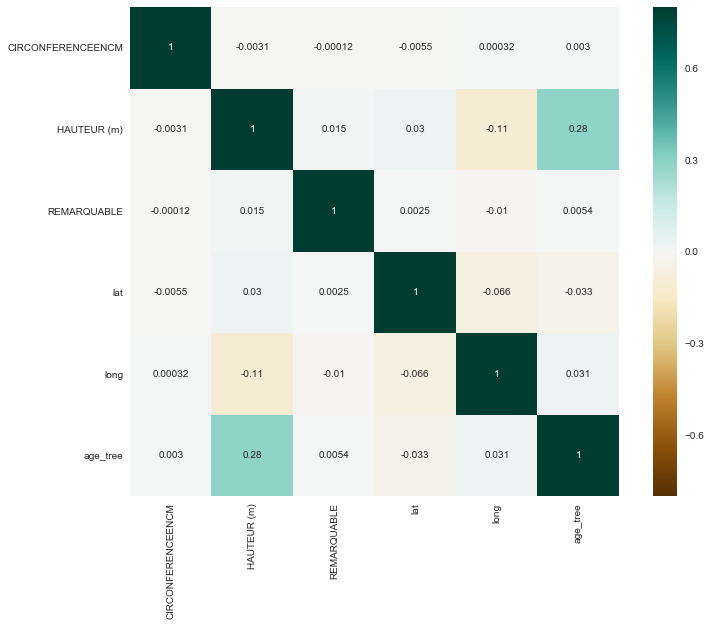

In [17]:
num = [x for x in df.columns if x not in categorical]
hmap = df[num].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(hmap, vmax=.8,annot=True,cmap="BrBG", square=True)

#### no strong correlations between numerical variables 
#### we note that hauteur is quite correlated with age tree (positively: 0.28) and negatively with longitude (-0.11)

DOMANIALITE


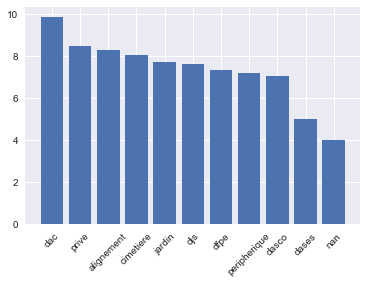

STADEDEVELOPPEMENT


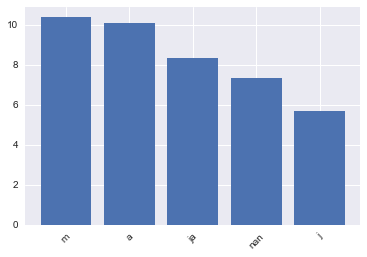

PEPINIERE


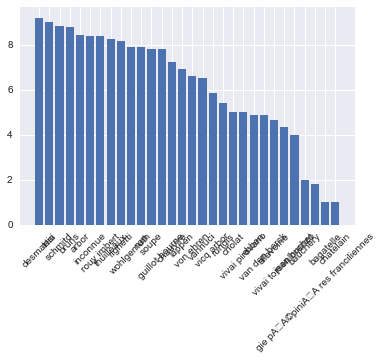

In [18]:
## for categorical with few modalities : plot bar chart : mean of hauteur 
var_few_mod = ['DOMANIALITE', 'STADEDEVELOPPEMENT', 'PEPINIERE']
for i in var_few_mod: 
    print(i)
    dfg = df[[i, 'HAUTEUR (m)']].groupby(i).mean().reset_index()
    dfg.sort_values('HAUTEUR (m)', ascending = False, inplace = True)
    plt.bar(range(0, len(dfg)), dfg['HAUTEUR (m)'], tick_label = dfg[i])#, tick_label = dfg[i]
    plt.xticks(rotation=45)
    plt.show()

    

#### there are some variations in "Hauteur" accross the modalities in each variable: strong variations for 'pepiniere', less strong 'Dominialité' and 'stade développpement' . Pepiniere will probably create a more important dummy features in the model 

## feature engineering 

### dummify categorical variables 

In [20]:
cols_to_dummy = [x for x in df.columns if type(df.get_value(0,x)) in [str, unicode]]
print('(variable, number of dummies)')
for i in cols_to_dummy: 
    print(i, len(set(df[i])))
    dummies = pd.get_dummies(df[i], prefix=i, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True)
    df.drop([i], axis = 1, inplace = True)
    df = pd.concat([dummies, df], axis= 1)
    

(variable, number of dummies)
('DOMANIALITE', 11)
('ARRONDISSEMENT', 25)
('STADEDEVELOPPEMENT', 5)
('PEPINIERE', 30)
('LIBELLEFRANCAIS', 174)
('month', 13)


### store target into array Y 

In [21]:
Y = df['HAUTEUR (m)'].values
df = df.drop('HAUTEUR (m)', axis =1) 

### impute missing values

In [22]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df)
X = imp.transform(df)

### slit between train and test (80/20)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# build regression model 

### First: estimate a simple linear regression in order to have a benchmark 

In [24]:
t0 = time.time()
lm = LinearRegression().fit(X_train, y_train)   
print('score', lm.score(X_test, y_test))
t1 = time.time()
total = (t1-t0)/60
print('Running time: ',total, 'min')
y_test_hat = lm.predict(X_test)
meanSquaredError=mean_squared_error(y_test, y_test_hat)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

('score', 0.47319562181734798)
('Running time: ', 0.04059999783833822, 'min')
('MSE:', 4.5796454376147731)
('RMSE:', 2.140010616238801)


## Second : estimate a gradient boosting regressor 

In [25]:

t0 = time.time()
clf = GradientBoostingRegressor().fit(X_train, y_train)     
print('score', clf.score(X_test, y_test))
t1 = time.time()
total = (t1-t0)/60
print('Running time: ', total, 'min')

('score', 0.65389263409782361)
('Running time: ', 3.5217833320299783, 'min')


In [26]:
clf.score(X_train, y_train) 

0.65492109264339105

#### very little over fitting as R2 scores on train and test are very close 

In [27]:
# compute MSE and RMSE on test 
y_test_hat = clf.predict(X_test)
meanSquaredError=mean_squared_error(y_test, y_test_hat)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)


('MSE:', 3.0088000115845763)
('RMSE:', 1.7345892919030073)


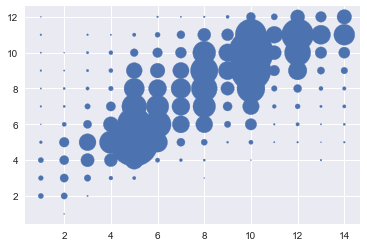

In [40]:
# make a scatter of y_true in x and y_pred in y 
# as most of the heights are integers: round predictions before plotting 
df_plot = pd.DataFrame({'y_true': list(y_test), 'y_pred': list(y_test_hat)})
df_plot = df_plot.applymap(round)
df_plot = df_plot.groupby(['y_true', 'y_pred']).size().reset_index(name = 'count')

plt.scatter(x = df_plot['y_true'], y = df_plot['y_pred'], s = df_plot['count'])
plt.show()

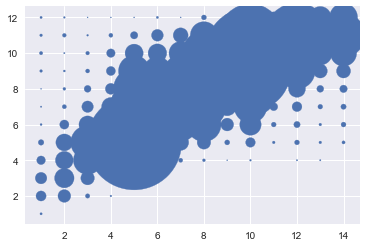

In [41]:
# make a scatter of y_true in x and y_pred in y 
# as most of the heights are integers: round predictions before plotting 
y_train_hat = clf.predict(X_train)
df_plot = pd.DataFrame({'y_true': list(y_train), 'y_pred': list(y_train_hat)})
df_plot = df_plot.applymap(round)
df_plot = df_plot.groupby(['y_true', 'y_pred']).size().reset_index(name = 'count')

plt.scatter(x = df_plot['y_true'], y = df_plot['y_pred'], s = df_plot['count'])
plt.show()

#### the model seeems less good at predicting low heights as the low ones, y_hat is more scattered 

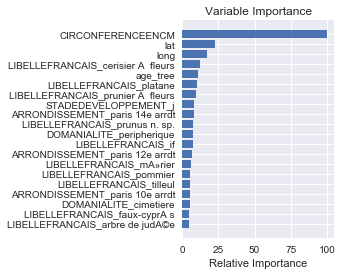

In [48]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [66]:
# try estimating GBM with top most important features 


In [77]:
X.shape

(128283L, 257L)

In [63]:
top50 = np.argsort(feature_importance)[-50:]
X_train2 = X_train[:,top50]
X_test2 = X_test[:,top50]

In [65]:

t0 = time.time()
clf = GradientBoostingRegressor().fit(X_train2, y_train)     
print('score', clf.score(X_test2, y_test))
t1 = time.time()
total = (t1-t0)/60
print('Running time: ', total, 'min')

('score', 0.65335740046577051)
('Running time: ', 0.40273333390553795, 'min')


#### same score but a lot faster 

### fine tune GBM parameters with grid search 

In [67]:
t0 = time.time()
param_test = {"n_estimators": [100,200,300,400, 600, 700, 800],\
        "max_depth": [3,4,5],\
        "max_features": [0.1,0.2,0.3,0.4,0.5],\
        "min_samples_leaf": [5, 10, 20, 25, 30]
        } 
        
n_iter_search = 40
model = GradientBoostingRegressor()
    
random_search = RandomizedSearchCV(\
        model,param_distributions=param_test,\
        n_iter=n_iter_search,cv=3)
random_search.fit(X_train2, y_train)      

bestModel = random_search.best_estimator_
print(random_search.best_params_)
bestModel.fit(X_train, y_train) 
print("score", bestModel.score(X_test2, y_test))

t1 = time.time()
total = (t1-t0)/60
print('Running time: ', total, 'min')

KeyboardInterrupt: 

In [ ]:
### interruption because to llong to run 

## apply transfo to our unlabelled data set and predict height 

In [72]:
def transform_df(df): 
    df.drop(cols_to_rm, axis =1, inplace = True)
    # convert geo_point_2D to lat / long 
    df['lat'],  df['long']= df['geo_point_2d'].map(lambda x: float(x.split(',', 1 )[0])), \
                            df['geo_point_2d'].map(lambda x: float(x.split(',', 1 )[1]))
    df.drop('geo_point_2d', axis= 1, inplace = True)
    # convert date 
    df['DATEPLANTATION'] = df['DATEPLANTATION'].map(lambda x: x if x > '1677' else np.nan) 
    ## NB: replace dates prior to 1677 as it is the min time boudery (pandas cannot convert to date values below this year)
    df['DATEPLANTATION'] = pd.to_datetime(df['DATEPLANTATION'], yearfirst = True)

    # feature engineering using date plantation 

    # compute age of tree
    df['age_tree'] = 2017 - df['DATEPLANTATION'].map(lambda x: x.year)

    df['month'] = df['DATEPLANTATION'].map(lambda x: str(x.month)) # compute month which we convert to string in order to 
    # dummify it later 

    # drop date 
    df.drop('DATEPLANTATION', axis = 1, inplace = True)

    # for the string variables: perform a bit of text processing
    for i in categorical: 
        # strip and put to lower case 
        df[i] = df[i].apply(lambda x: str(x).strip().lower())
        # decode with latin 1 -> often does the trick with French character when utf-8 does not work 
        df[i] = df[i].apply(lambda x: x.decode('latin-1'))
        # remove accent 
        df[i] = df[i].apply(lambda x: remove_accents(x))

    df.drop(['GENRE', 'ESPECE'], axis = 1, inplace = True)
    cols_to_dummy = ['DOMANIALITE', 'ARRONDISSEMENT', 'STADEDEVELOPPEMENT', 'PEPINIERE', 'LIBELLEFRANCAIS', 'month']

    for i in cols_to_dummy: 
        dummies = pd.get_dummies(df[i], prefix=i, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True)
        df.drop([i], axis = 1, inplace = True)
        df = pd.concat([dummies, df], axis= 1)

    df = df.drop('HAUTEUR (m)', axis =1) 
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(df)
    X = imp.transform(df)
    X = X[:,top50]
    return X

In [81]:
df = pd.read_csv(path, sep = ';')
index_0 = df[df['HAUTEUR (m)']==0].index
df0 = df[df['HAUTEUR (m)']==0]

In [82]:
X = transform_df(df)

In [83]:
X0 = X[index_0,:]

In [84]:
y_pred = clf.predict(X0)
df0['HAUTEUR (m)'] = y_pred 

C:\Users\kmontali\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [85]:
# save data set 
df0.to_csv('arbres_prediction.csv', index = False)